In [2]:
!pip install pillow

In [31]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from PIL import Image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models

%matplotlib inline

In [4]:
DATA_DIR = '../input/cat-and-dog'
print(os.listdir(DATA_DIR))

['test_set', 'training_set']


In [5]:
classes = os.listdir(DATA_DIR + '/test_set/test_set')
classes

['cats', 'dogs']

In [6]:
len(os.listdir(DATA_DIR + '/test_set/test_set/cats'))

1012

In [7]:
# transformation
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transform = tt.Compose([tt.Resize(360),
                              tt.RandomCrop(360, padding=4, padding_mode='reflect'),
                              tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                              tt.RandomHorizontalFlip(),
                              tt.RandomRotation(10),
                              tt.ToTensor(),
                              tt.Normalize(*stats, inplace=True),
                              tt.RandomErasing(inplace=True)])

#normalizing the validation image size before transforming to tensor
valid_transform = tt.Compose([tt.Resize(360),
                              tt.CenterCrop(360),
                              tt.ToTensor(),
                              tt.Normalize(*stats)])

In [8]:
# Pytorch datasets
'''
ImageFolder is one of best the function for data that is separated by classes. Along with transformations, it also appends label by itself. 
The label is index of class in the working directory. (It follows Zero-Indexing Scheme)
'''
train_ds = ImageFolder(DATA_DIR + '/training_set/training_set', valid_transform)
test_ds = ImageFolder(DATA_DIR+'/test_set/test_set' ,train_transform)

    

In [9]:
# Checking some labels of the datasets

#For Dogs
c = 0
for i in reversed(train_ds):
    print(i[1])
    c += 1
    if c > 10:
        break
        
# For Cats
c = 0
for i in (test_ds):
    print(i[1])
    c += 1
    if c > 10:
        break
        
# Since, they're ordered in folders(Classes).The data is contiguous for respective classes.
# We'll shuffle them by using DataLoaders very soon.

1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0


In [10]:
torch.manual_seed(664)
test_size = int(len(test_ds)/2)
val_size = len(test_ds) - test_size
test_ds, val_ds = random_split(test_ds, [test_size, val_size])

In [11]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

8005
1011
1012


In [12]:
# DataLoaders will help the model train efficiently by loading by groups.
# shuffle = True is very important for our ordered data

batch_size = 18
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)


In [13]:
for img, _ in train_dl:
    print(img.size())
    break

torch.Size([18, 3, 360, 360])


In [14]:
def show_sample(dl):
    for img, lbl in dl:
        print('images.shape:', img.shape)
        print('example label:', lbl)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img[:batch_size], nrow=8).permute(1, 2, 0))
        break

images.shape: torch.Size([18, 3, 360, 360])
example label: tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1])


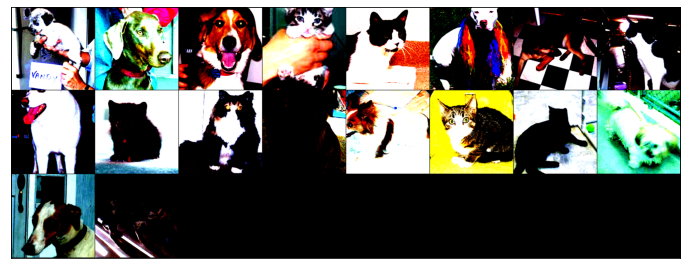

In [15]:
show_sample(train_dl)

## **Setting Up GPU Suport**



In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
torch.cuda.empty_cache()

## Let's push the tensors on CUDA...🙌

In [23]:
if device == torch.device('cuda'):
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)
#   test_dl = DeviceDataLoader(test_dl, device)

## Following pipeline is same for most of the basic models.

In [57]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, max_lr, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        lrs = []
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## Implementing Conv2D

In [58]:
class CatsNDogs(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 360, kernel_size=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(360, 720, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(720, 1024, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(1024, 720, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(720, 360, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(360, 256, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)
    
model = CatsNDogs()


In [59]:
class CatDogRes(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained = True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, batch):
        return torch.sigmoid(self.network(batch))
        
        
        
model = CatDogRes()       
    

In [60]:
model

CatDogRes(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [61]:
torch.cuda.empty_cache()
to_device(model, device)

CatDogRes(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [62]:
max_lr = 0.01

In [63]:
history = fit(4, model, train_dl, valid_dl, max_lr)

Epoch [0], val_loss: 0.3841, val_acc: 0.9291
Epoch [1], val_loss: 0.3580, val_acc: 0.9531
Epoch [2], val_loss: 0.3545, val_acc: 0.9607
Epoch [3], val_loss: 0.3470, val_acc: 0.9703


In [101]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    

In [102]:
def predict_single(image, lbl):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds
    print(prediction)
    show_sample(image, prediction)
    if prediction[0][0] > prediction[0][1]:
        print(prediction[0][0], lbl, 'Cat') 
    else:
        print(prediction[0][1], lbl, 'Dog')
    
#     print("Prediction: ", prediction)
#     show_sample(image, prediction)

In [103]:
img, lbl = test_ds[11]

img.size()

torch.Size([3, 360, 360])

tensor([[0.5360, 0.4799]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.5360, device='cuda:0', grad_fn=<SelectBackward>) 1 Cat


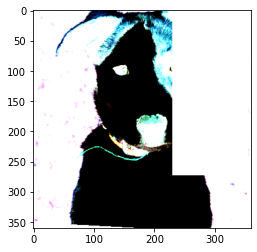

In [104]:
predict_single(img, lbl)